# Modeling

## Contents

- [Imports](#Imports)
- [Preprocessing](#Preprocessing)
- [Model Instantiation](#Model-Instantiation)
    - [Logistic Regression](#Logistic-Regression)
    - [KNearest Neighbors](#KNearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [RandomForest Classifier](#RandomForest-Classifier)
    - [SVM](#SVM)
    - [Adaboost](#Adaboost)
- [Additional Modeling](#Additional-Modeling)
    - [Predictions](#Predictions)
    - [Evaluation](#Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                   import metrics
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics           import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.linear_model      import LogisticRegression
from sklearn.pipeline          import Pipeline
from sklearn.naive_bayes       import MultinomialNB
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm               import SVC


import requests
import time

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
%matplotlib inline

## Preprocessing

In [2]:
df = pd.read_csv('./Data_Files/model_single_season.csv', index_col = 0)

In [3]:
df.head()

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,...,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G
0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,...,22.50,0,0,0,1,0,0,0,0,1
1,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,...,17.75,0,0,0,0,0,0,1,1,0
2,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,...,11.57,0,0,0,0,0,0,1,1,0
3,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,...,15.16,0,0,0,0,1,0,0,1,0
4,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,...,16.29,0,0,0,0,1,0,0,0,1


We are going to create a testing dataframe from the original dataset. The testing dataframe will include all the players drafted in the 2019 draft. These players have yet to play in the NBA, therefore, could not have made an all-star game. Our goal will be to predict the probability that these players make the game in their career.

In [4]:
#creating testing set dataframe
test_df = df[df['year'] == 2019]

In [5]:
#removing 2019 from the original dataframe
df = df[df['year'] != 2019]

We are going to adjust the index to be equal to the player name + the school + the draft pick. This will make it possible to see which players correspond to our predicted probabilities after running the models.

In [9]:
#creating column
df['player_index'] = df['player_name'] + ': ' + df['school'] + ': ' + df['pick'].astype(str)

In [10]:
#setting index
df.set_index(df['player_index'], inplace = True)

In [11]:
#dropping newly created columns
df.drop(columns = ['player_index'], inplace = True)

In [12]:
df.head()

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,...,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G
player_index,,,,,,,,,,,,,,,,,,,,,
Charles Jenkins: Hofstra: 44.0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,...,22.50,0,0,0,1,0,0,0,0,1
Richard Hendrix: Alabama: 49.0,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,...,17.75,0,0,0,0,0,0,1,1,0
Vernon Macklin: Florida: 52.0,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,...,11.57,0,0,0,0,0,0,1,1,0
Maarty Leunen: Oregon: 54.0,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,...,15.16,0,0,0,0,1,0,0,1,0
Malik Hairston: Oregon: 48.0,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,...,16.29,0,0,0,0,1,0,0,0,1


In [13]:
df.columns

Index(['player_name', 'school', 'GP', 'Min_per', 'ORtg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA_x',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'porpag', 'adjoe', 'pfr',
       'year', 'pid', 'ast/tov', 'pick', 'drtg', 'adrtg', 'dporpag', 'stops',
       'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'all_star',
       'total_points', 'PPG', 'conference_B10', 'conference_B12',
       'conference_BE', 'conference_Non_major', 'conference_P10',
       'conference_P12', 'conference_SEC', 'Pos_F', 'Pos_G'],
      dtype='object')

### Feature Selection

 - Including all numerical features at first

In [14]:
#features to drop 
drop = ['player_name','school', 'year', 'pid', 'pick', 'all_star']

In [15]:
features = df.drop(columns = drop).columns
X = df[features]
y = df['all_star']

In [16]:
X.shape

(530, 50)

In [17]:
y.shape

(530,)

### Train/Test Split

In [18]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### Scaling

In [19]:
ss = StandardScaler()
ss.fit(X_train) 
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

## Model Instantiation

### Logistic Regression

In [20]:
lr = LogisticRegression()

lr_params = {
    'C': [.001, .01, 0.1, 0.5, 1, 5, 10],
    'penalty': ['l1', 'l2']
}

gs = GridSearchCV(lr, param_grid=lr_params, cv=3, verbose = 1)
gs_sc = GridSearchCV(lr, param_grid=lr_params, cv=3, verbose = 1)
gs.fit(X_train, y_train)
gs_sc.fit(X_train_sc, y_train)
print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)
print('Scaled')
print(f'CrossVal Score: {gs_sc.best_score_}')
print(f'Training Score: {gs_sc.score(X_train_sc, y_train)}')
print(f'Testing Score: {gs_sc.score(X_test_sc, y_test)}')
print(gs_sc.best_params_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits
Unscaled
CrossVal Score: 0.947103274559194
Training Score: 0.9521410579345088
Testing Score: 0.9097744360902256
{'C': 0.01, 'penalty': 'l2'}
Scaled
CrossVal Score: 0.9445843828715366
Training Score: 0.9445843828715366
Testing Score: 0.9398496240601504
{'C': 0.001, 'penalty': 'l1'}


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.4s finished


In [21]:
gs_sc.predict_proba(X_test)[:10]

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [22]:
1 - y.mean()

0.9433962264150944

**Discuss results**

### KNearest Neighbors

In [23]:
knn = KNeighborsClassifier()

knn_params = {'n_neighbors': [5, 10, 15],
              'weights': ['uniform', 'distance']
}

gs_sc = GridSearchCV(knn, param_grid=knn_params, cv=3, verbose = 1)
gs_sc.fit(X_train_sc, y_train)

print('Scaled')
print(f'CrossVal Score: {gs_sc.best_score_}')
print(f'Training Score: {gs_sc.score(X_train_sc, y_train)}')
print(f'Testing Score: {gs_sc.score(X_test_sc, y_test)}')
print(gs_sc.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Scaled
CrossVal Score: 0.9445843828715366
Training Score: 0.9445843828715366
Testing Score: 0.9398496240601504
{'n_neighbors': 10, 'weights': 'uniform'}


In [24]:
1 - y_test.mean()

0.9398496240601504

In [25]:
gs_sc.predict_proba(X_test)[:10]

array([[0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.9, 0.1]])

**Discuss Results**

### Decision Tree

In [26]:
dt = DecisionTreeClassifier(random_state = 42)

dt_params = {}

gs = GridSearchCV(dt, param_grid=dt_params, cv=3, verbose = 1)
gs_sc = GridSearchCV(dt, param_grid=dt_params, cv=3, verbose = 1)
gs.fit(X_train, y_train)
gs_sc.fit(X_train_sc, y_train)
print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)
print('Scaled')
print(f'CrossVal Score: {gs_sc.best_score_}')
print(f'Training Score: {gs_sc.score(X_train_sc, y_train)}')
print(f'Testing Score: {gs_sc.score(X_test_sc, y_test)}')
print(gs_sc.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Unscaled
CrossVal Score: 0.871536523929471
Training Score: 1.0
Testing Score: 0.924812030075188
{}
Scaled
CrossVal Score: 0.871536523929471
Training Score: 1.0
Testing Score: 0.9172932330827067
{}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [27]:
dt = DecisionTreeClassifier(random_state = 42)

dt_params = {'max_depth': [5,10, 15, 50],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 3, 4]
}

gs = GridSearchCV(dt, param_grid=dt_params, cv=3, verbose = 1)
gs_sc = GridSearchCV(dt, param_grid=dt_params, cv=3, verbose = 1)
gs.fit(X_train, y_train)
gs_sc.fit(X_train_sc, y_train)
print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Unscaled
CrossVal Score: 0.924433249370277
Training Score: 0.964735516372796
Testing Score: 0.9398496240601504
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3}


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.5s finished


In [28]:
gs.predict_proba(X_test)[:10]

array([[1.        , 0.        ],
       [0.85714286, 0.14285714],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.94736842, 0.05263158],
       [0.5       , 0.5       ],
       [1.        , 0.        ],
       [0.94736842, 0.05263158],
       [0.94736842, 0.05263158],
       [1.        , 0.        ]])

**Discuss Results**

### RandomForest Classifier

In [29]:
rf = RandomForestClassifier(random_state = 42)

rf_params = {}

gs = GridSearchCV(rf, param_grid = rf_params, cv=3, verbose = 1)
gs.fit(X_train, y_train)

print('Unscaled')
print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
print(gs.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Unscaled
CrossVal Score: 0.947103274559194
Training Score: 0.9848866498740554
Testing Score: 0.9323308270676691
{}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [30]:
rf = RandomForestClassifier(random_state = 42)

rf_params = {'n_estimators': [50, 60, 70],
             'max_depth': [None, 50],
             'min_samples_split': [2, 3, 5, 7],
             'min_samples_leaf': [1, 2, 3, 4]}

rf_gs = GridSearchCV(rf, param_grid=rf_params, cv=3, verbose = 1)
rf_gs.fit(X_train, y_train)

print('Unscaled')
print(f'CrossVal Score: {rf_gs.best_score_}')
print(f'Training Score: {rf_gs.score(X_train, y_train)}')
print(f'Testing Score: {rf_gs.score(X_test, y_test)}')
print(rf_gs.best_params_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Unscaled
CrossVal Score: 0.947103274559194
Training Score: 0.9949622166246851
Testing Score: 0.9398496240601504
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}


[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   16.0s finished


In [31]:
rf_gs.predict_proba(X_test)[:10]

array([[0.81666667, 0.18333333],
       [0.92666667, 0.07333333],
       [0.995     , 0.005     ],
       [0.89      , 0.11      ],
       [0.69      , 0.31      ],
       [0.86666667, 0.13333333],
       [1.        , 0.        ],
       [0.9       , 0.1       ],
       [0.83666667, 0.16333333],
       [0.96666667, 0.03333333]])

**Discuss Results**

### SVM

In [32]:
# Instantiate SVM.
svc = SVC(
    C=5,
    kernel="rbf",
    gamma="scale"
)

# Fit on training data.
svc.fit(X_train, y_train)

# Evaluate model.
print(f'Training Score: {svc.score(X_train, y_train)}')
print(f'Testing Score: {svc.score(X_test, y_test)}')

Training Score: 0.9445843828715366
Testing Score: 0.9398496240601504


In [ ]:
#predict proba doesn't work
#svc.predict_proba(X_test)

**Discuss Results**

### Adaboost

In [33]:
ada = AdaBoostClassifier()
ada_params = {
    'base_estimator': [LogisticRegression(C = .5, penalty = 'l1')], 
    'n_estimators': [25, 50, 75],
    'learning_rate': [.9, 1.]}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3, n_jobs = 2, verbose = 1)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   35.6s finished


CrossVal Score: 0.9445843828715366
Training Score: 0.9445843828715366
Testing Score: 0.9398496240601504


{'base_estimator': LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'learning_rate': 0.9,
 'n_estimators': 25}

In [34]:
gs.predict_proba(X_test)[:10]

array([[0.53682186, 0.46317814],
       [0.53088378, 0.46911622],
       [0.54313086, 0.45686914],
       [0.52604465, 0.47395535],
       [0.51703893, 0.48296107],
       [0.53838748, 0.46161252],
       [0.53211577, 0.46788423],
       [0.52045954, 0.47954046],
       [0.52845566, 0.47154434],
       [0.5364637 , 0.4635363 ]])

In [35]:
ada = AdaBoostClassifier(base_estimator= DecisionTreeClassifier())
ada_params = {
    'n_estimators': [40, 50, 60],
    'base_estimator__max_depth': [1, 2, 3]
}
gs = GridSearchCV(ada, param_grid= ada_params, cv = 5)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

CrossVal Score: 0.9496221662468514
Training Score: 1.0
Testing Score: 0.9398496240601504


{'base_estimator__max_depth': 3, 'n_estimators': 40}

In [36]:
gs.predict_proba(X_test)[:10]

array([[9.76726595e-01, 2.32734054e-02],
       [9.36395071e-01, 6.36049286e-02],
       [9.99999531e-01, 4.69492834e-07],
       [9.99854837e-01, 1.45162959e-04],
       [9.99018769e-01, 9.81230794e-04],
       [9.99981314e-01, 1.86863113e-05],
       [9.99690034e-01, 3.09965611e-04],
       [9.99782382e-01, 2.17618011e-04],
       [9.98184855e-01, 1.81514472e-03],
       [9.99996901e-01, 3.09855291e-06]])

In [37]:
ada = AdaBoostClassifier(base_estimator= DecisionTreeClassifier())
ada_params = {
    'n_estimators': [25, 50, 75, 100],
    'base_estimator__max_depth': [1, 2, 3, 4],
    'base_estimator__min_samples_leaf': [2, 5],
    'base_estimator__min_samples_split': [2,5]
    
}
gs = GridSearchCV(ada, param_grid= ada_params, cv = 5, verbose = 1)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CrossVal Score: 0.9496221662468514
Training Score: 1.0
Testing Score: 0.924812030075188


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.0min finished


{'base_estimator__max_depth': 2,
 'base_estimator__min_samples_leaf': 2,
 'base_estimator__min_samples_split': 5,
 'n_estimators': 25}

In [38]:
gs.predict_proba(X_test)[:10]

array([[0.92753021, 0.07246979],
       [0.78995062, 0.21004938],
       [0.98684802, 0.01315198],
       [0.99416076, 0.00583924],
       [0.67737187, 0.32262813],
       [0.99122382, 0.00877618],
       [0.77257436, 0.22742564],
       [0.82889395, 0.17110605],
       [0.34879503, 0.65120497],
       [0.99604855, 0.00395145]])

In [39]:
ada = AdaBoostClassifier(base_estimator= RandomForestClassifier())
ada_params = {
    'n_estimators': [25, 50, 75],
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [2, 5],
    'base_estimator__min_samples_split': [2,5]
}
gs = GridSearchCV(ada, param_grid= ada_params, cv = 5)
gs.fit(X_train, y_train)

print(f'CrossVal Score: {gs.best_score_}')
print(f'Training Score: {gs.score(X_train, y_train)}')
print(f'Testing Score: {gs.score(X_test, y_test)}')
gs.best_params_

CrossVal Score: 0.9445843828715366
Training Score: 1.0
Testing Score: 0.9398496240601504


{'base_estimator__max_depth': 1,
 'base_estimator__min_samples_leaf': 2,
 'base_estimator__min_samples_split': 2,
 'n_estimators': 75}

In [40]:
1 - y_test.mean()

0.9398496240601504

In [41]:
gs.predict_proba(X_test)[:10]

array([[0.54073436, 0.45926564],
       [0.52784198, 0.47215802],
       [0.56618629, 0.43381371],
       [0.53408576, 0.46591424],
       [0.51364455, 0.48635545],
       [0.53232113, 0.46767887],
       [0.52481569, 0.47518431],
       [0.53564724, 0.46435276],
       [0.5313208 , 0.4686792 ],
       [0.55723158, 0.44276842]])

In [42]:
gs.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

**Discuss Results**

## Predictions

#### Training Data

In [43]:
#creating column in X_train df with the predicted probability
X_train['all_star_prob'] = rf_gs.predict_proba(X_train)[:, 1]

In [44]:
#adding target variable back in for evaluation
X_train['all_star'] = y_train

In [45]:
#creating column in X_test df with the predicted probability
X_test['all_star_prob'] = rf_gs.predict_proba(X_test)[:, 1]

In [46]:
#adding target variable back in for evaluation
X_test['all_star'] = y_test

In [47]:
#Combining dataframes for evaluation
train_df = pd.concat([X_train, X_test])

In [48]:
#rounding values
train_df['all_star_prob'] = np.round(train_df['all_star_prob'], 2)

In [90]:
#adding column for the index
#will be used to split out name, school and draft pick
train_df['player_index'] = train_df.index

In [94]:
#creating columns for player name, school and draft pick to be used for evaluation
train_df[['player', 'school', 'pick']] = train_df['player_index'].str.split(': ', expand = True)

In [96]:
#dropping player index column
train_df.drop(columns = ['player_index'], inplace = True)

In [100]:
#adjusting data type of draft pick to be numeric
train_df['pick'] = train_df['pick'].astype(float)

In [49]:
#looking at top 10 most likely players to become an All-Star
train_df.sort_values(by = 'all_star_prob', ascending = False).head(20)

,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,all_star_prob,all_star
player_index,,,,,,,,,,,,,,,,,,,,,
Kevin Love: UCLA: 5.0,38,74.1,127.0,27.2,59.2,64.24,15.3,28.6,13.8,14.8,...,0,0,0,1,0,0,0,0,0.83,1
Stephen Curry: Davidson: 7.0,33,82.1,118.0,37.5,54.9,60.46,1.8,12.3,39.8,16.6,...,0,0,1,0,0,0,0,1,0.80,1
Anthony Davis: Kentucky: 1.0,40,80.1,133.8,19.1,62.8,65.41,11.6,23.9,7.5,10.0,...,0,0,0,0,0,1,1,0,0.78,1
Karl-Anthony Towns: Kentucky: 1.0,39,52.3,122.7,24.2,57.0,62.72,14.1,22.2,11.5,16.6,...,0,0,0,0,0,1,1,0,0.70,1
John Wall: Kentucky: 1.0,37,83.9,108.7,26.9,50.3,56.18,2.7,10.1,34.8,24.2,...,0,0,0,0,0,1,0,1,0.69,1
Draymond Green: Michigan St.: 35.0,37,82.8,107.3,28.2,50.4,54.22,8.2,28.5,24.2,19.7,...,0,0,0,0,0,0,1,0,0.68,1
DeMarcus Cousins: Kentucky: 5.0,38,58.2,113.5,30.8,56.0,57.93,19.9,24.9,9.2,16.0,...,0,0,0,0,0,1,1,0,0.68,1
Kawhi Leonard: San Diego St.: 15.0,34,79.6,108.7,27.7,46.3,50.78,11.4,25.9,16.4,15.1,...,0,0,1,0,0,0,1,0,0.67,1
Gordon Hayward: Butler: 9.0,37,81.2,113.3,24.4,52.7,60.13,7.6,23.4,12.1,17.5,...,0,0,1,0,0,0,1,0,0.66,1


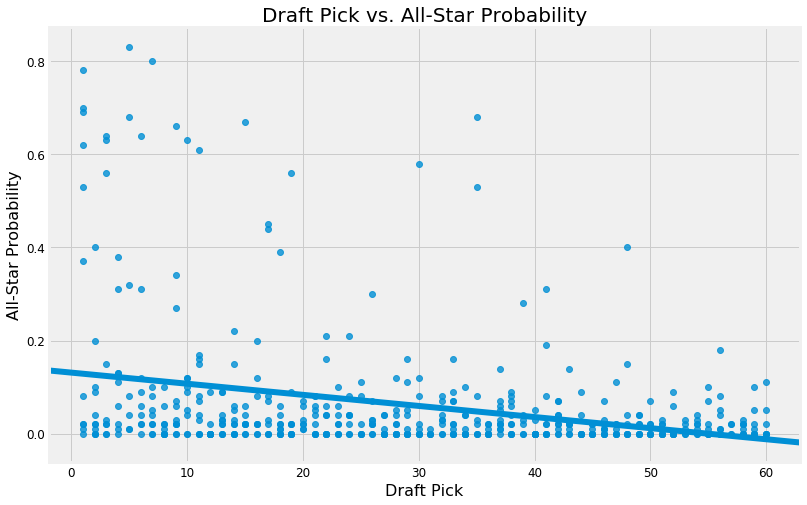

In [108]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'pick', y= 'all_star_prob', data = train_df, ci = None)
plt.xlabel('Draft Pick', size = 16)
plt.ylabel('All-Star Probability', size = 16)
plt.title('Draft Pick vs. All-Star Probability', size = 20)
plt.xticks(size = 12)
plt.yticks(size = 12);

**Add Comments**

#### Test Data

In [50]:
#test data from 2019
test_df[features].head()

,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,PPG,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G
409,34,79.9,111.9,26.9,57.1,61.08,5.1,11.7,12.2,17.6,...,18.74,0,1,0,0,0,0,0,0,1
427,36,89.3,109.6,23.8,52.8,57.00,4.2,16.0,12.9,16.2,...,16.53,0,0,1,0,0,0,0,1,0
454,31,95.0,95.5,36.3,45.5,51.53,3.2,22.4,33.0,17.3,...,22.26,0,0,0,1,0,0,0,0,1
456,32,84.4,111.6,29.9,54.8,58.67,6.6,23.8,15.4,15.4,...,19.22,0,0,0,1,0,0,0,1,0
458,32,83.7,126.6,24.7,64.9,68.03,6.8,27.2,13.4,13.6,...,21.56,0,0,0,1,0,0,0,0,1


In [51]:
#creating a variable to feed into predict function for probabilities
test_proba = test_df[features]

In [52]:
#feeding in test dataframe into fit model for predictions
rf_gs.predict(test_proba)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0])

In [53]:
#feeding in test dataframe into fit model for probabilities
rf_gs.predict_proba(test_proba)[:5]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.84666667, 0.15333333],
       [0.98      , 0.02      ],
       [0.92      , 0.08      ]])

In [54]:
#creating a variable with each players All-Star probability
all_star_proba = rf_gs.predict_proba(test_proba)[:, 1]

In [55]:
all_star_proba[:15]

array([0.        , 0.        , 0.15333333, 0.02      , 0.08      ,
       0.025     , 0.        , 0.        , 0.17666667, 0.03      ,
       0.35      , 0.        , 0.04      , 0.02      , 0.        ])

In [56]:
#adding probabilities to test dataframe
test_df['all_star_prob'] = np.round(all_star_proba, 2)

In [57]:
#looking at probabilities from greatest to least likelihood
test_df.sort_values(by = 'all_star_prob', ascending = False).head(10)

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,...,conference_B10,conference_B12,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,all_star_prob
572,Zion Williamson,Duke,33,64.9,129.2,28.2,70.8,70.19,12.8,18.0,...,0,0,0,0,0,0,0,1,0,0.56
485,Brandon Clarke,Gonzaga,37,70.2,134.3,24.0,69.3,69.89,13.9,19.7,...,0,0,0,1,0,0,0,1,0,0.35
540,Ja Morant,Murray St.,31,93.5,115.6,36.0,54.7,60.77,4.1,12.6,...,0,0,0,1,0,0,0,0,1,0.22
574,Bol Bol,Oregon,9,17.6,116.5,30.4,61.0,63.18,9.7,29.0,...,0,0,0,0,0,1,0,0,0,0.19
481,Matisse Thybulle,Washington,36,77.2,103.2,17.2,50.0,54.17,3.0,9.0,...,0,0,0,0,0,1,0,0,1,0.18
579,Jaxson Hayes,Texas,32,50.0,133.8,16.9,72.8,73.90,8.8,16.2,...,0,1,0,0,0,0,0,1,0,0.17
454,Justin James,Wyoming,31,95.0,95.5,36.3,45.5,51.53,3.2,22.4,...,0,0,0,1,0,0,0,0,1,0.15
578,Tyler Herro,Kentucky,37,81.0,118.2,20.0,53.6,58.03,1.6,14.0,...,0,0,0,0,0,0,1,0,1,0.15
525,Grant Williams,Tennessee,36,78.6,124.5,27.0,58.3,64.73,8.8,17.4,...,0,0,0,0,0,0,1,1,0,0.14
544,Jarrett Culver,Texas Tech,38,80.6,106.9,32.2,50.5,54.17,5.7,17.3,...,0,1,0,0,0,0,0,0,1,0.13


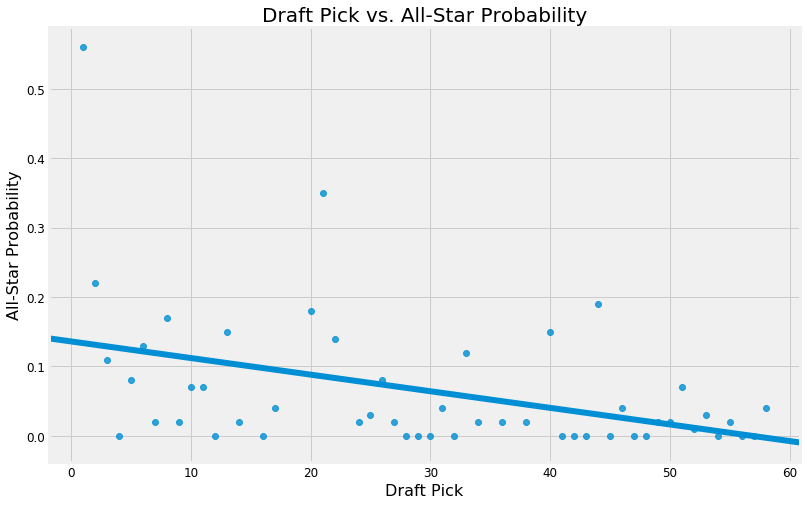

In [107]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'pick', y= 'all_star_prob', data = test_df, ci = None)
plt.xlabel('Draft Pick', size = 16)
plt.ylabel('All-Star Probability', size = 16)
plt.title('Draft Pick vs. All-Star Probability', size = 20)
plt.xticks(size = 12)
plt.yticks(size = 12);

**Add Comments**

## Additional Modeling

We are going to reduce the number of features fed into the model and will focus on the RandomForest model which previously predicted the best results and had the most realistic probabilities. We will be using the single season csv file that also contains columns engineered through Bayes statistics.

### Preprocessing

In [58]:
df2 = pd.read_csv('./Data_Files/model_single_season_bayes.csv', index_col = 0)
df2.head()

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,...,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg
0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,...,69,0.785489,89,99,155,0.388889,141,226,193,0.539568
1,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,...,124,0.591362,5,38,71,0.345794,149,277,201,0.579832
2,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,...,87,0.574257,0,36,66,0.350000,131,241,183,0.568720
3,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,...,61,0.752066,61,95,127,0.427273,63,148,115,0.563218
4,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,...,68,0.718487,68,88,134,0.395455,91,174,143,0.549206


In [59]:
#creating testing set dataframe
test_df2 = df2[df2['year'] == 2019]

In [60]:
#removing 2019 from the original dataframe
df2 = df2[df2['year'] != 2019]

In [61]:
#creating new column that will become the index
df2['player_index'] = df2['player_name'] + ': ' + df2['school'] + ': ' + df2['pick'].astype(str)

In [62]:
#setting index
df2.set_index(df2['player_index'], inplace = True)

In [63]:
#dropping newly created columns
df2.drop(columns = ['player_index'], inplace = True)

In [64]:
df2.head()

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,...,new_FT_misses,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg
player_index,,,,,,,,,,,,,,,,,,,,,
Charles Jenkins: Hofstra: 44.0,Charles Jenkins,Hofstra,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,...,69,0.785489,89,99,155,0.388889,141,226,193,0.539568
Richard Hendrix: Alabama: 49.0,Richard Hendrix,Alabama,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,...,124,0.591362,5,38,71,0.345794,149,277,201,0.579832
Vernon Macklin: Florida: 52.0,Vernon Macklin,Florida,37,59.7,107.5,24.3,59.3,57.77,10.9,15.0,...,87,0.574257,0,36,66,0.350000,131,241,183,0.568720
Maarty Leunen: Oregon: 54.0,Maarty Leunen,Oregon,32,85.8,135.3,19.0,66.4,69.59,7.9,23.5,...,61,0.752066,61,95,127,0.427273,63,148,115,0.563218
Malik Hairston: Oregon: 48.0,Malik Hairston,Oregon,31,75.4,121.7,23.3,60.3,63.04,5.8,12.6,...,68,0.718487,68,88,134,0.395455,91,174,143,0.549206


### Feature Selection

We are going to drop columns that are used in the calculation of other variables. For example, Free throws attempted and free throws made are divided to get free throw percentage. We are going to leave the percentage column in my analysis. The percentage columns for free throws, 2-point shooting and 3-point shooting have been adjusted using bayesian statistics. Calculations can be seen in **Data Scrape - Team Stats for Bayes Analysis** in the **Data_Collection** folder. Other features will be removed if they act similarly when a player is an All-Star or not an All-Star.

In [65]:
df2.columns

Index(['player_name', 'school', 'GP', 'Min_per', 'ORtg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA_x',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'porpag', 'adjoe', 'pfr',
       'year', 'pid', 'ast/tov', 'pick', 'drtg', 'adrtg', 'dporpag', 'stops',
       'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'all_star',
       'total_points', 'PPG', 'conference_B10', 'conference_B12',
       'conference_BE', 'conference_Non_major', 'conference_P10',
       'conference_P12', 'conference_SEC', 'Pos_F', 'Pos_G', 'FT_misses',
       'new_FTM', 'new_FT_misses', 'new_FT_avg', '3P_misses', 'new_TPM',
       'new_3P_misses', 'new_3P_avg', '2P_misses', 'new_2PM', 'new_2P_misses',
       'new_2P_avg'],
      dtype='object')

In [66]:
#features to drop 
drop = ['player_name','school','Min_per','TS_per','FTM','FT_per','twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
        'pfr','year', 'pid','ast/tov', 'pick', 'all_star','stops', 'gbpm', 'ogbpm', 'mp', 'ht', 'drtg','ORtg',
        'dgbpm', 'total_points', 'FT_misses', 'new_FTM', 'new_FT_misses', '3P_misses', 'new_TPM', 'new_3P_misses',
        '2P_misses', 'new_2PM', 'new_2P_misses']


In [67]:
features = df2.drop(columns = drop).columns
X2 = df2[features]
y2 = df2['all_star']

In [68]:
print(X2.shape)
y2.shape

(530, 32)


(530,)

### Train/Test Split

In [69]:
#train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 42, stratify = y2)

### Model Instantiation

In [70]:
rf2 = RandomForestClassifier(random_state = 42)

rf2_params = {}

rf2_gs = GridSearchCV(rf2, param_grid = rf2_params, cv=3, verbose = 1)
rf2_gs.fit(X2_train, y2_train)

print(f'CrossVal Score: {rf2_gs.best_score_}')
print(f'Training Score: {rf2_gs.score(X2_train, y2_train)}')
print(f'Testing Score: {rf2_gs.score(X2_test, y2_test)}')
print(rf2_gs.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CrossVal Score: 0.9445843828715366
Training Score: 0.982367758186398
Testing Score: 0.9323308270676691
{}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [71]:
rf2 = RandomForestClassifier(random_state = 42)

rf2_params = {'n_estimators': [50, 60, 70],
             'max_depth': [None, 10, 25, 50],
             'min_samples_split': [2, 3, 4, 5],
             'min_samples_leaf': [1, 2, 3, 4, 5]}

rf2_gs = GridSearchCV(rf2, param_grid=rf2_params, cv=3, verbose = 1)
rf2_gs.fit(X2_train, y2_train)

print('Unscaled')
print(f'CrossVal Score: {rf2_gs.best_score_}')
print(f'Training Score: {rf2_gs.score(X2_train, y2_train)}')
print(f'Testing Score: {rf2_gs.score(X2_test, y2_test)}')
print(rf2_gs.best_params_)


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Unscaled
CrossVal Score: 0.947103274559194
Training Score: 0.9974811083123426
Testing Score: 0.9398496240601504
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   38.3s finished


In [72]:
rf2_gs.predict(X2_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [73]:
rf2_gs.predict_proba(X2_test)[:10]

array([[0.88, 0.12],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.74, 0.26],
       [0.88, 0.12],
       [0.86, 0.14],
       [0.96, 0.04],
       [0.9 , 0.1 ],
       [0.94, 0.06],
       [1.  , 0.  ]])

### Predictions

#### Training Data

In [74]:
#creating column in X_train df with the predicted probability
X2_train['all_star_prob'] = rf2_gs.predict_proba(X2_train)[:, 1]

In [75]:
#adding target variable back in for evaluation
X2_train['all_star'] = y2_train

In [76]:
#creating column in X_test df with the predicted probability
X2_test['all_star_prob'] = rf2_gs.predict_proba(X2_test)[:, 1]

In [77]:
#adding target variable back in for evaluation
X2_test['all_star'] = y2_test

In [78]:
#Combining dataframes for evaluation
train_df2 = pd.concat([X2_train, X2_test])

In [79]:
#rounding values
train_df2['all_star_prob'] = np.round(train_df2['all_star_prob'], 2)

In [101]:
#adding column for the index
#will be used to split out name, school and draft pick
train_df2['player_index'] = train_df2.index

In [102]:
#creating columns for player name, school and draft pick to be used for evaluation
train_df2[['player', 'school', 'pick']] = train_df2['player_index'].str.split(': ', expand = True)

In [103]:
#dropping player index column
train_df2.drop(columns = ['player_index'], inplace = True)

In [104]:
#adjusting data type of draft pick to be numeric
train_df2['pick'] = train_df2['pick'].astype(float)

In [105]:
#looking at top 10 most likely players to become an All-Star
train_df2.sort_values(by = 'all_star_prob', ascending = False).head(20)

,GP,usg,eFG,ORB_per,DRB_per,AST_per,TO_per,FTA_x,blk_per,stl_per,...,Pos_F,Pos_G,new_FT_avg,new_3P_avg,new_2P_avg,all_star_prob,all_star,player,school,pick
player_index,,,,,,,,,,,,,,,,,,,,,
Anthony Davis: Kentucky: 1.0,40,19.1,62.8,11.6,23.9,7.5,10.0,203,13.7,2.5,...,1,0,0.706271,0.316667,0.613909,0.90,1,Anthony Davis,Kentucky,1.0
Stephen Curry: Davidson: 7.0,33,37.5,54.9,1.8,12.3,39.8,16.6,241,0.7,3.9,...,0,1,0.826979,0.379391,0.511364,0.84,1,Stephen Curry,Davidson,7.0
Kevin Love: UCLA: 5.0,38,27.2,59.2,15.3,28.6,13.8,14.8,251,5.0,1.5,...,0,0,0.749288,0.351648,0.579710,0.80,1,Kevin Love,UCLA,5.0
John Wall: Kentucky: 1.0,37,26.9,50.3,2.7,10.1,34.8,24.2,232,1.5,2.9,...,0,1,0.737952,0.336449,0.504717,0.74,1,John Wall,Kentucky,1.0
Joel Embiid: Kansas: 3.0,28,24.4,62.9,12.7,27.3,11.5,24.1,143,11.7,2.3,...,0,0,0.691358,0.342857,0.582707,0.72,1,Joel Embiid,Kansas,3.0
Kawhi Leonard: San Diego St.: 15.0,34,27.7,46.3,11.4,25.9,16.4,15.1,145,1.9,2.8,...,1,0,0.734694,0.320442,0.475584,0.72,1,Kawhi Leonard,San Diego St.,15.0
Klay Thompson: Washington St.: 11.0,34,31.9,52.5,2.6,14.0,25.0,17.8,185,3.1,2.8,...,0,1,0.789474,0.384393,0.471605,0.70,1,Klay Thompson,Washington St.,11.0
Karl-Anthony Towns: Kentucky: 1.0,39,24.2,57.0,14.1,22.2,11.5,16.6,134,11.4,1.4,...,1,0,0.764957,0.342593,0.551724,0.70,1,Karl-Anthony Towns,Kentucky,1.0
Draymond Green: Michigan St.: 35.0,37,28.2,50.4,8.2,28.5,24.2,19.7,173,3.4,2.7,...,1,0,0.714286,0.371795,0.477169,0.68,1,Draymond Green,Michigan St.,35.0


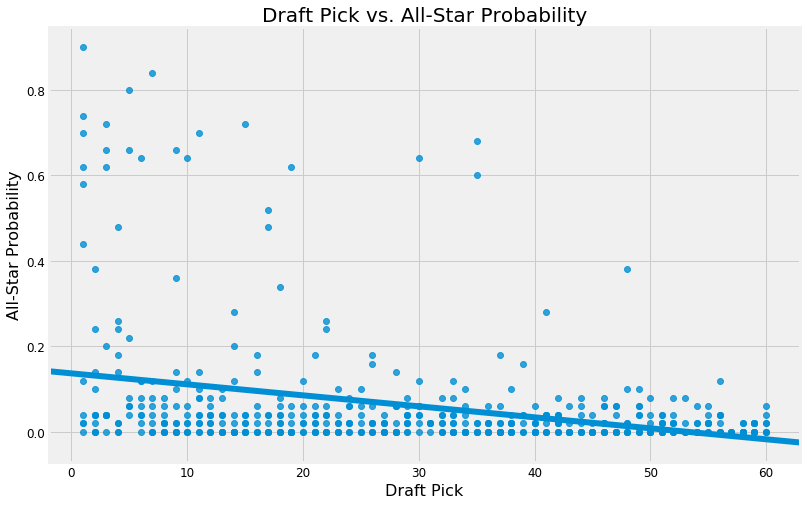

In [106]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'pick', y= 'all_star_prob', data = train_df2, ci = None)
plt.xlabel('Draft Pick', size = 16)
plt.ylabel('All-Star Probability', size = 16)
plt.title('Draft Pick vs. All-Star Probability', size = 20)
plt.xticks(size = 12)
plt.yticks(size = 12);

**add comments**

#### Testing Data

In [81]:
#looking at dataframe of test set
test_df2[features].head()

,GP,usg,eFG,ORB_per,DRB_per,AST_per,TO_per,FTA_x,blk_per,stl_per,...,conference_BE,conference_Non_major,conference_P10,conference_P12,conference_SEC,Pos_F,Pos_G,new_FT_avg,new_3P_avg,new_2P_avg
409,34,26.9,57.1,5.1,11.7,12.2,17.6,123,0.8,1.7,...,0,0,0,0,0,0,1,0.798206,0.371930,0.547619
427,36,23.8,52.8,4.2,16.0,12.9,16.2,181,1.6,1.2,...,1,0,0,0,0,1,0,0.729537,0.348837,0.519403
454,31,36.3,45.5,3.2,22.4,33.0,17.3,260,1.6,2.2,...,0,1,0,0,0,0,1,0.730556,0.319392,0.463768
456,32,29.9,54.8,6.6,23.8,15.4,15.4,156,3.0,2.4,...,0,1,0,0,0,1,0,0.750000,0.328638,0.556064
458,32,24.7,64.9,6.8,27.2,13.4,13.6,135,1.7,2.4,...,0,1,0,0,0,0,1,0.787234,0.402439,0.606349


In [82]:
#predictions on test set
rf2_gs.predict(test_df2[features])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [83]:
#probabilities on test set
rf2_gs.predict_proba(test_df2[features])[:5]

array([[1.  , 0.  ],
       [0.96, 0.04],
       [0.92, 0.08],
       [1.  , 0.  ],
       [0.96, 0.04]])

In [84]:
#creating variable equal to All-Star probability
all_star_proba2 = rf2_gs.predict_proba(test_df2[features])[:, 1]

In [85]:
#creating column with the probabilities
test_df2['all_star_prob'] = np.round(all_star_proba2, 2)

In [86]:
#sorting values by all-star probability in descending order
test_df2.sort_values(by = 'all_star_prob', ascending = False).head(10)

,player_name,school,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,...,new_FT_avg,3P_misses,new_TPM,new_3P_misses,new_3P_avg,2P_misses,new_2PM,new_2P_misses,new_2P_avg,all_star_prob
572,Zion Williamson,Duke,33,64.9,129.2,28.2,70.8,70.19,12.8,18.0,...,0.660066,47,60,113,0.345029,92,322,144,0.691810,0.46
485,Brandon Clarke,Gonzaga,37,70.2,134.3,24.0,69.3,69.89,13.9,19.7,...,0.696498,11,40,77,0.339130,106,303,158,0.657952,0.34
544,Jarrett Culver,Texas Tech,38,80.6,106.9,32.2,50.5,54.17,5.7,17.3,...,0.704545,112,85,178,0.321839,185,255,237,0.518367,0.30
525,Grant Williams,Tennessee,36,78.6,124.5,27.0,58.3,64.73,8.8,17.4,...,0.784916,30,50,96,0.340278,146,265,198,0.572668,0.22
573,R.J. Barrett,Duke,38,87.9,108.0,31.3,50.6,53.19,4.8,17.2,...,0.675926,164,109,230,0.320475,219,296,271,0.522124,0.20
540,Ja Morant,Murray St.,31,93.5,115.6,36.0,54.7,60.77,4.1,12.6,...,0.782730,96,92,162,0.361111,162,244,214,0.532895,0.16
574,Bol Bol,Oregon,9,17.6,116.5,30.4,61.0,63.18,9.7,29.0,...,0.715328,12,49,78,0.384000,46,111,98,0.531401,0.14
578,Tyler Herro,Kentucky,37,81.0,118.2,20.0,53.6,58.03,1.6,14.0,...,0.813472,109,96,175,0.353160,108,176,160,0.523952,0.10
576,Darius Garland,Vanderbilt,5,10.8,110.1,26.9,63.9,65.75,1.6,13.7,...,0.706897,12,47,78,0.373984,13,68,65,0.511450,0.10
481,Matisse Thybulle,Washington,36,77.2,103.2,17.2,50.0,54.17,3.0,9.0,...,0.760479,105,82,171,0.322709,53,116,105,0.525114,0.10


### Evaluation

In [87]:
show_columns = ['player_name', 'school', 'pick' , 'all_star_prob']
test_df2[show_columns].sort_values(by = 'all_star_prob', ascending = False).head()


,player_name,school,pick,all_star_prob
572,Zion Williamson,Duke,1.0,0.46
485,Brandon Clarke,Gonzaga,21.0,0.34
544,Jarrett Culver,Texas Tech,6.0,0.30
525,Grant Williams,Tennessee,22.0,0.22
573,R.J. Barrett,Duke,3.0,0.20


In [88]:
test_df2[test_df2['all_star_prob'] > .05][show_columns].sort_values(by = 'all_star_prob', ascending = False)

,player_name,school,pick,all_star_prob
572,Zion Williamson,Duke,1.0,0.46
485,Brandon Clarke,Gonzaga,21.0,0.34
544,Jarrett Culver,Texas Tech,6.0,0.30
525,Grant Williams,Tennessee,22.0,0.22
573,R.J. Barrett,Duke,3.0,0.20
540,Ja Morant,Murray St.,2.0,0.16
574,Bol Bol,Oregon,44.0,0.14
481,Matisse Thybulle,Washington,20.0,0.10
561,Bruno Fernando,Maryland,34.0,0.10
576,Darius Garland,Vanderbilt,5.0,0.10


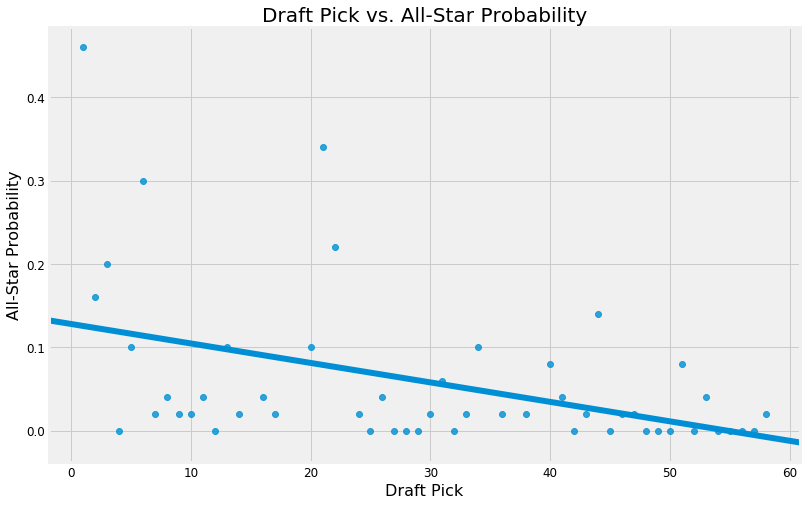

In [89]:
plt.figure(figsize = (12, 8))
sns.regplot(x = 'pick', y= 'all_star_prob', data = test_df2, ci = None)
plt.xlabel('Draft Pick', size = 16)
plt.ylabel('All-Star Probability', size = 16)
plt.title('Draft Pick vs. All-Star Probability', size = 20)
plt.xticks(size = 12)
plt.yticks(size = 12);

Based off of our model, Zion Williamson has by far the highest likelihood of becoming an All-Star at some point in his career. Higher draft picks tended to be associated with higher probabilities. This reveals that front offices may have selected well in the 2019 NBA draft. However, Brandon Clarke, had the second highest probability of becoming an All-Star and he was selected 21st overall. **(Add in why his probability is so high)** Please note that draft position was not included in our model since the goal of this tool is to be used prior to drafting players.

## Conclusions and Recommendations